# import

In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from pyvino.model.model import Model
from pyvino.util.config import TASKS
from pyvino.util.image import imshow, cam_test, cv2pil
from pyvino.detector.detector import DetectorBody, DetectorHumanPose

https://www.youtube.com/watch?v=Pv6Cimz4-WE

# path

In [2]:
notebook_name = os.path.basename(os.getcwd())
timestamp = notebook_name.split('_')[1]
timestamp

'07'

In [3]:
path_movie_dir = '../data/movie/fps30_mask/'
path_save_dir = os.path.join('../data/03_PlotPoints/', timestamp)
if not os.path.exists(path_save_dir):
    os.makedirs(path_save_dir)

In [4]:
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints/', timestamp)

In [5]:
file_names = ['forehand', 'backhand', 'foreslice', 'backslice', 'test']
# file_names = ['forehand']
movie_names = [file_name + '.mp4' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

In [6]:
path_label_name_file = '../data/labels/labels_num.csv'

In [60]:
num = 1
path_action = os.path.join(path_action_dir, points_file_names[num])
path_point = os.path.join(path_point_dir, points_file_names[num])
action_df = pd.read_csv(path_action)
point_df = pd.read_csv(path_point)

In [61]:
input_data = os.path.join(path_movie_dir, movie_names[num])
# input_data = '../data/[HD] Roger Federer _ Practice BNP Paribas Open 2019 Part 1.mp4'

In [62]:
point_df.head()

,Nose_x,Nose_y,Neck_x,Neck_y,RShoulder_x,RShoulder_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,...,LAnkle_x,LAnkle_y,REye_x,REye_y,LEye_x,LEye_y,REar_x,REar_y,LEar_x,LEar_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
label_names = pd.read_csv(path_label_name_file)

In [64]:
objective = 'action_gt_name'

In [65]:
action_dict = label_names.to_dict()[objective]

# model

In [66]:
TASKS

{'detect_face': 'face-detection-adas-0001',
 'emotion_recognition': 'emotions-recognition-retail-0003',
 'estimate_headpose': 'head-pose-estimation-adas-0001',
 'detect_body': 'person-detection-retail-0013',
 'estimate_humanpose': 'human-pose-estimation-0001',
 'detect_segmentation': 'instance-segmentation-security-0050'}

In [67]:
task = 'detect_body'
task = 'estimate_humanpose'

In [68]:
det_h = DetectorHumanPose()

2019-09-15 21:13:57,139 - pyvino.detector.detector - INFO - human-pose-estimation-0001 on Darwin
2019-09-15 21:13:57,140 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib
2019-09-15 21:13:57,398 - pyvino.detector.detector - INFO - person-detection-retail-0013 on Darwin
2019-09-15 21:13:57,399 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib


In [69]:
det_h.BODY_PARTS

{'Nose': 0,
 'Neck': 1,
 'RShoulder': 2,
 'RElbow': 3,
 'RWrist': 4,
 'LShoulder': 5,
 'LElbow': 6,
 'LWrist': 7,
 'RHip': 8,
 'RKnee': 9,
 'RAnkle': 10,
 'LHip': 11,
 'LKnee': 12,
 'LAnkle': 13,
 'REye': 14,
 'LEye': 15,
 'REar': 16,
 'LEar': 17}

In [70]:
body_parts_list = list(det_h.BODY_PARTS.keys())

# movie

In [71]:
cap = cv2.VideoCapture(input_data)

In [72]:
# 幅
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# 高さ
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# 総フレーム数
count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# fps
fps = int(cap.get(cv2.CAP_PROP_FPS))

# compute

In [73]:
times = np.arange(0, len(point_df))

In [74]:
start = 0
end = max(times)

In [75]:
body_parts = det_h.POSE_PARTS_FLATTEN[0:len(det_h.POSE_PARTS_FLATTEN)-2]
body_parts

['Nose_x',
 'Nose_y',
 'Neck_x',
 'Neck_y',
 'RShoulder_x',
 'RShoulder_y',
 'RElbow_x',
 'RElbow_y',
 'RWrist_x',
 'RWrist_y',
 'LShoulder_x',
 'LShoulder_y',
 'LElbow_x',
 'LElbow_y',
 'LWrist_x',
 'LWrist_y',
 'RHip_x',
 'RHip_y',
 'RKnee_x',
 'RKnee_y',
 'RAnkle_x',
 'RAnkle_y',
 'LHip_x',
 'LHip_y',
 'LKnee_x',
 'LKnee_y',
 'LAnkle_x',
 'LAnkle_y',
 'REye_x',
 'REye_y',
 'LEye_x',
 'LEye_y',
 'REar_x',
 'REar_y']

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


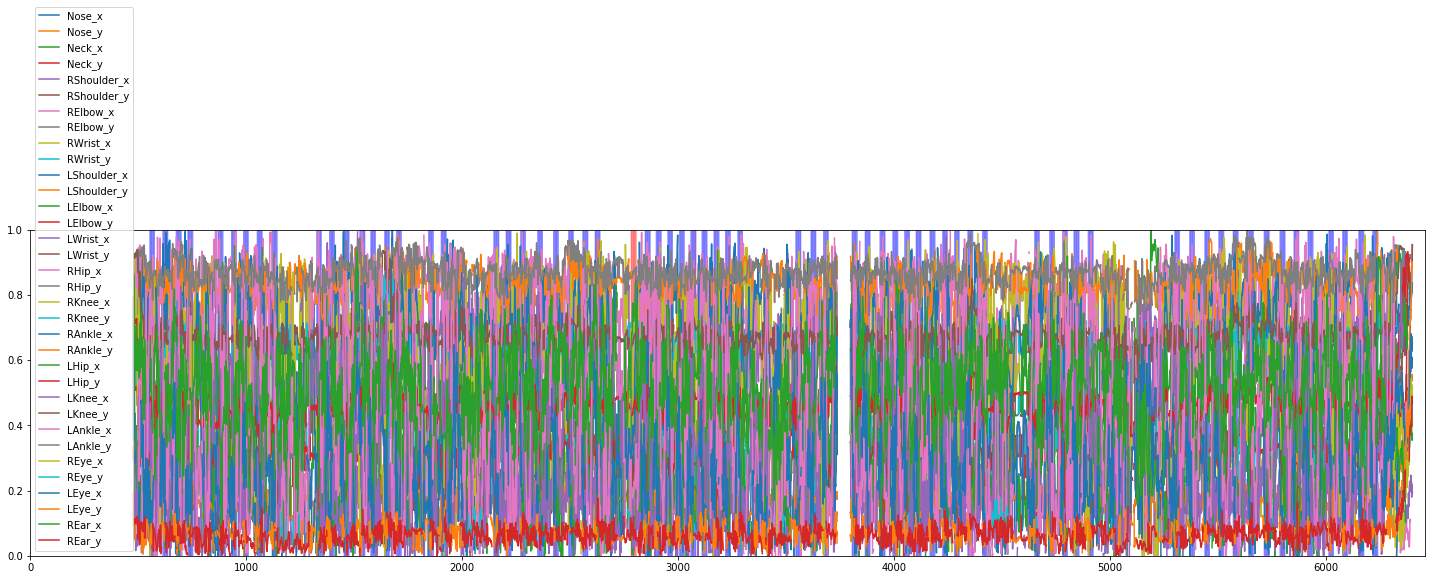

In [76]:
plt.figure(figsize=(25,6))
for body_part in body_parts:
    plt.plot(times, point_df[body_part], label=body_part)
    plt.xlim(0, end)
    plt.ylim(0, 1)
    
for frame_count in action_df.index:
    action = action_df.loc[frame_count]['action_gt_num']
    if action == 1:
        plt.axvspan(frame_count, frame_count+1, 0, 1, color = "red", alpha=0.1)
    elif action == 2:
        plt.axvspan(frame_count, frame_count+1, 0, 1, color = "blue", alpha=0.1)
    elif action == 3:
        plt.axvspan(frame_count, frame_count+1, 0, 1, color = "green", alpha=0.1)
    elif action == 4:
        plt.axvspan(frame_count, frame_count+1, 0, 1, color = "yellow", alpha=0.1)
plt.legend()
plt.show()

In [77]:
actions = action_df['action_gt_num']

In [78]:
action_start = []
action_end = []
action_types = []

last_action = 0
idle = 0
for num, action in enumerate(actions):
    if (action != last_action) and (action != 0):
        action_start.append(num)
        action_types.append(action)
    elif (action != last_action) and (action == 0):
        action_end.append(num)
    last_action = action
action_types = np.asarray(action_types)
action_start = np.asarray(action_start)
action_end = np.asarray(action_end)

In [79]:
action_ranges = np.empty((0 ,3))
action_range = np.zeros(3)

last_action = 0
idle = 0
for num, action in enumerate(actions):
    
    if (action != last_action) and (action != 0):
        action_range[0] = num
        action_range[2] = action
    elif (action != last_action) and (action == 0):
        action_range[1] = num
        action_ranges = np.vstack([action_ranges, action_range])
        action_range = np.zeros(3)
    last_action = action
action_ranges = action_ranges.astype(int)

In [80]:
action_dict

{0: 'idle', 1: 'forehand', 2: 'backhand', 3: 'foreslice', 4: 'backslice'}

In [81]:
action_color = {'idle': 'green', 'forehand': 'red', 'backhand': 'blue'}
action_num_color_dict = {0: 'green', 1: 'red', 2: 'blue', 3: 'orange', 4: 'skyblue'}

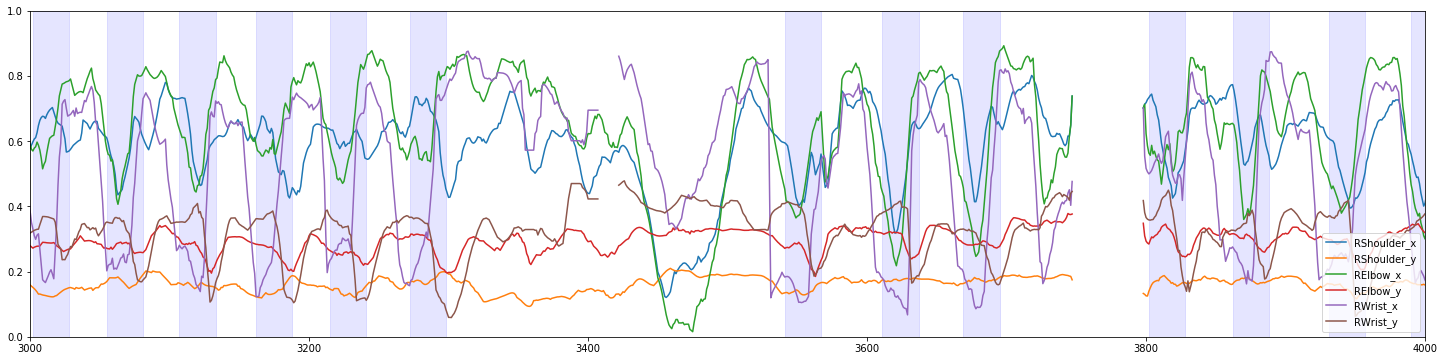

In [82]:
plt.figure(figsize=(25,6))
for action_range in action_ranges:
    plt.axvspan(action_range[0], action_range[1], 0, 1, color = action_num_color_dict[action_range[2]], alpha=0.1)

for body_part in ['RShoulder_x',
 'RShoulder_y',
 'RElbow_x',
 'RElbow_y',
 'RWrist_x',
 'RWrist_y',]:
    plt.plot(times, point_df.rolling(12, min_periods=1).mean()[body_part], label=body_part)
    plt.xlim(3000, 4000)
    plt.ylim(0, 1)
        
plt.legend(loc='lower right')
plt.show()

# movie

In [27]:
model = Model(task='estimate_humanpose')

2019-09-05 09:35:12,965 - pyvino.detector.detector - INFO - human-pose-estimation-0001 on Darwin
2019-09-05 09:35:12,966 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib
2019-09-05 09:35:13,190 - pyvino.detector.detector - INFO - person-detection-retail-0013 on Darwin
2019-09-05 09:35:13,191 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib


In [71]:
cap = cv2.VideoCapture(input_data)
# cap.set(3, 640)
# cap.set(4, 480)
cap.set(3, 480)
cap.set(4, 360)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = np.array(frame)
    ############################
    frame = det_h.compute(frame, frame_flag=True)['frame']
    ############################

    cv2.imshow('demo', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/pyvino-0.0.1-py3.6.egg/pyvino/detector/detector.py:533: RuntimeWarning: invalid value encountered in greater
/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/pyvino-0.0.1-py3.6.egg/pyvino/detector/detector.py:535: RuntimeWarning: invalid value encountered in greater
